# SQUWALS Tutorial

In this notebook we will show a tutorial of how to use SQUWALS [[1]](Simulator), our simulator of Szegedy's quantum walks [[2]](https://ieeexplore.ieee.org/document/1366222).

This simulator uses an algorithm that need memory resources scaling as $\mathcal{O}(N^2)$.

It is recommended to read section II from [[1]](Simulator) for terminology.

## Table of Contents

- [Packages](#0)
- [1 - Column Stochastic Matrix](#1)
- [2 - Initial State](#2)
- [3 - Unitary Operators](#3)
    - [3.1 - Reflection](#3-1)
    - [3.2 - Swap](#3-2)
    - [3.3 - Oracle](#3-3)
    - [3.4 - Unitary Operator](#3-4)
    - [3.5 - Default Unitary Operators](#3-2)
- [4 - Measurement](#4)
- [5 - Szegedy Quantum Walk Simulator](#5)
- [6 - Mixed State Simulation](#6)
- [7 - Example: Szegedy's Quantum Walk with Queries](#7)
- [8 - References](#8)

<a name='0'></a>
## Packages
First we import the libraries that we need.First we import the libraries that we need, including our simulator.

In [1]:
import numpy as np
import squwals as sw
import matplotlib.pyplot as plt

<a name='1'></a>
## 1 - Column Stochastic Matrix
First, we need the transition matrix of a classical walk $G$, whose elements $G_{ji}$ are the probabilities of the walker jumping from node $i$ to node $j$. This is a $N\times N$ column-stochastic matrix, so that the elements of each column add up to one. Thus:

$$\sum_{i=0}^{N-1} G_{ij} \ \forall \ j.$$

**Note: Depending on the literature, the transition matrix is defined as row-stochastic, so that it corresponds to our $G^T$. For this simulator we ALWAYS need a column-stochastic matrix.**

We will create a random column-stochastic matrix.

In [2]:
# Define the number of nodes of the graph.
N = 4

# Create a random matrix and noramlize the columns so that their elements add up to one.
rng = np.random.default_rng(seed=32)
G = rng.random([N,N])
G = G / sum(G)

Let's check that the sums of the elements along the first dimension are equal to 1.

In [3]:
np.sum(G,axis=0)

array([1., 1., 1., 1.])

<a name='2'></a>
## 2 - Initial State

The Hilbert space is the span of all the vectors representing the $N \times N$ directed edges of the duplicated graph, i.e., $\mathcal{H} = \text{span}\lbrace\left|i\right>_1\left|j\right>_2,\ i,j = 0,1,...,N-1\rbrace = \mathbb{C}^N \otimes \mathbb{C}^N$, where the states with indexes $1$ and $2$ refer to the nodes on two copies of the original graph. Thus, the states are defined over two quantum registers. Therefore, any quantum state is represented by a $N^2$-dimensional vector.

We need an initial quantum state over which to perform the quantum evolution. An usual initial state is defined as

\begin{equation}
	\left|\Psi^{(0)}\right> = \frac{1}{\sqrt{N}}\sum_{i=0}^{N-1}\left|\psi_i\right>,
\end{equation}

where the states

\begin{equation}\label{psi_i}
	\left|\psi_i\right> := \left|i\right>_1 \otimes \sum_{k=0}^{N-1} \sqrt{G_{ki}}\left|k\right>_2
\end{equation}
are created using the transition matrix $G$.

We provide the function `create_initial_state`, which takes as unique argument the transition matrix, and returns the state $\left|\Psi^{(0)}\right>$ as a 1D numpy array.

In [4]:
initial_state = sw.create_initial_state(G)
initial_state

array([0.1326066 , 0.27449354, 0.30181543, 0.25685839, 0.22144811,
       0.28865017, 0.19848592, 0.27972335, 0.21344498, 0.34175299,
       0.19571313, 0.22213172, 0.19664959, 0.28352618, 0.2548929 ,
       0.25684909])

<a name='3'></a>
## 3 - Unitary operators

The quantum walk operator $U$ is usually defined as

\begin{equation}\label{U}
	U := SR,
\end{equation}

where $R$ is a reflection over the subspace generated by the $\left|\psi_i\right>$ states,

\begin{equation}\label{reflection}
R = 2\Pi - \mathbb{1}, \ \ \ \ \ \ \Pi := \sum_{i=0}^{N-1} \left|\psi_i\right>\left<\psi_i\right|,
\end{equation}

and $S$ is the swap operator between the two quantum registers, i.e.,

\begin{equation}\label{swap}
	S := \sum_{i,j=0}^{N-1} \left|i,j\right>\left<j,i\right|.
\end{equation}

However, there exist other formulations, as the double Szegedy operator $U = SRSR$.

**Note: The original formulation of the unitary is as two reflections, $U = R_BR_A$, where $R_A = R$ and $R_B = SRS$. Thus, it corresponds to the double Szegedy operator in our notation.**

Finally, the unitary operator can be modified introducing oracles in the context of quantum search. Let us define the operator $Q$ as follows:

\begin{equation}\label{oracle}
Q = \mathbb{1}_N - 2\sum_{k \in \mathcal{M}} \left|k\right>\left<k\right|,
\end{equation}

which inverts the sign of the vectors $\left|k\right>$ given a set $\mathcal{M}$ of nodes to mark. In order to mark the nodes in the first register, we use the oracle $Q_1$ defined as:

\begin{equation}
Q_1 = Q \otimes \mathbb{1}_N,
\end{equation}

whereas to mark them in the second register, we use $Q_2$:

\begin{equation}
Q_2 = \mathbb{1}_N \otimes Q.
\end{equation}

Any Szegedy-like quantum operator can be expressed in terms of the reflection $R$, the swap $S$ and the oracles $Q_1$ and $Q_2$. Thus, we will see how to create these operators, and use them to build the unitary quantum evolution $U$.

<a name='3-1'></a>
### 3.1 - Reflection

We provide the `Reflection` class. To instantiate a reflection object we need to pass as argument the transition matrix $G$.

In [5]:
# Create a reflection object using G
R = sw.Reflection(transition_matrix=G)

We can use the method `info()` to obtain information about the operator.

In [6]:
R.info()

Reflection


In this case the information is trivial. However, we can create a more complicated reflection operator.

We can add a phase for arbitrary phase rotation, so that the operator becomes:

\begin{equation}
R(\theta) = (1-e^{i\theta})\Pi - \mathbb{1}.
\end{equation}

The angle $\theta$ is passed by the optional argument `apr_phase`. Let's use $\theta = \pi/2$.

In [7]:
R_apr = sw.Reflection(G,apr_phase=np.pi/2)
R_apr.info()

Reflection: apr_phase = 1.57


We can also use the extended Szegedy model, where the states $\left|\psi_i\right>$ are modified as

\begin{equation}\label{psi_i_phases}
	\left|\psi_i\right> := \sum_{k=0}^{N-1} e^{\theta_{ik}}\sqrt{G_{ki}}\left|i\right>_1\left|k\right>_2,
\end{equation}

We need a matrix with all the angles $\theta_{ij}$, and pass it by the argument `extended_phases`.

In [8]:
theta_matrix = np.random.random([N,N])
R_extended = sw.Reflection(G,extended_phases=theta_matrix)
R_extended.info()

Reflection (extended model)


In this case we do not show explicitly the phases due to the large number of them. However, they can be retrieved with the attribute `extended_phases`.

In [9]:
theta_matrix

array([[0.4268129 , 0.19569158, 0.88984997, 0.12340595],
       [0.91129816, 0.42749972, 0.10683814, 0.9101485 ],
       [0.86029826, 0.41776569, 0.89399457, 0.08815782],
       [0.07450153, 0.21365318, 0.67957883, 0.76523936]])

In [10]:
R_extended.extended_phases

array([[0.4268129 , 0.19569158, 0.88984997, 0.12340595],
       [0.91129816, 0.42749972, 0.10683814, 0.9101485 ],
       [0.86029826, 0.41776569, 0.89399457, 0.08815782],
       [0.07450153, 0.21365318, 0.67957883, 0.76523936]])

Finally, we can give a custom name to the operator with the argument `name`

In [11]:
R_all = sw.Reflection(G,apr_phase=np.pi/2,extended_phases=theta_matrix,name='custom reflection')
R_all.info()

Reflection custom reflection (extended model): apr_phase = 1.57


<a name='3-2'></a>
### 3.2 - Swap

We provide the `Swap` class. No arguments are needed.

In [12]:
S = sw.Swap()
S.info()

Swap


<a name='3-3'></a>
### 3.3 - Oracle

We provide the `Oracle` class. The arguments are the following:

-    register: An intenger indicating the register for marking: 1 or 2.
-    marked_nodes: A list with the nodes to mark.
-    phase: Angle for the arbitrary phase rotation (optional).
-    name: Custom name for the oracle operator.

Let's create an oracle that marks nodes 0 and 2 in the first register.

In [13]:
Q_1 = sw.Oracle(1,marked_nodes=[0,2])
Q_1.info()

Oracle: Register 1: nodes [0, 2]


The list of marked nodes can be retrieved with the attribute `marked_nodes`.

In [14]:
Q_1.marked_nodes

[0, 2]

Now let's mark in the second register and add an arbitrary phase rotation. In this case the operator $Q$ becomes

\begin{equation}\label{oracle_phase}
	Q(\theta) = \mathbb{1}_N - (1-e^{i\theta})\sum_{k \in M} \left|k\right>\left<k\right|.
\end{equation}

In [15]:
Q_custom = sw.Oracle(2,marked_nodes=[0,2],phase=0.3,name='custom')
Q_custom.info()

Oracle custom: Register 2: nodes [0, 2], phase = 0.30


<a name='3-4'></a>
### 3.4 - Unitary Operator

Now that we have seen how to create the building blocks, we can join them into an unitary operator $U$. Let's create the operator

$$U = SRSRQ_1.$$

Note that the order of action of the operators is read from right to left. Thus, the first operator is the oracle $Q_1$.

We can create an unitary object with the `Unitary` class, and use the `append` method to introduce the building blocks.

In [16]:
U = sw.Unitary()

# First we add the oracle
U.append(Q_1)

# Secondly the reflection
U.append(R)

# And so on
U.append(S)
U.append(R)
U.append(S)

We can use the `info()` method to see the information of the unitary operator.

In [17]:
U.info()

Custom unitary:
 1 - Oracle: Register 1: nodes [0, 2]
 2 - Reflection
 3 - Swap
 4 - Reflection
 5 - Swap


Moreover, we can print the operator to obtain its algebraic representation.

In [18]:
print(U)

SRSRQ₁


Another form of initializing the unitary is passing a list with the operators. The first operator of the list is the first one acting.

In [19]:
U = sw.Unitary(operators=[Q_1,R,S,R,S])
print(U)
U.info()

SRSRQ₁
Custom unitary:
 1 - Oracle: Register 1: nodes [0, 2]
 2 - Reflection
 3 - Swap
 4 - Reflection
 5 - Swap


Finally, other form of constructing the unitary operator is multiplying the different operators in an algebraic sense, using `*`.

In [20]:
U = S * R * S * R * Q_1
print(U)
U.info()

SRSRQ₁
Custom unitary:
 1 - Oracle: Register 1: nodes [0, 2]
 2 - Reflection
 3 - Swap
 4 - Reflection
 5 - Swap


We can give it a custom name with the argument `name` when it is built with the `Unitary` class.

In [21]:
U = sw.Unitary(operators=[Q_1,R,S,R,S],name='custom')
print(U)
U.info()

SRSRQ₁
Custom unitary: custom
 1 - Oracle: Register 1: nodes [0, 2]
 2 - Reflection
 3 - Swap
 4 - Reflection
 5 - Swap


The unitary operators can also be multiplied in an algebraic sense, using the operator `*`.

In [22]:
U_2 = sw.Unitary([R,S,S,S,Q_custom,S])
print(U_2)
U_2.info()

SQ₂SSSR
Custom unitary:
 1 - Reflection
 2 - Swap
 3 - Swap
 4 - Swap
 5 - Oracle custom: Register 2: nodes [0, 2], phase = 0.30
 6 - Swap


In [23]:
U_product = U * U_2
print(U_product)
U_product.info()

SRSRQ₁SQ₂SSSR
Custom unitary:
 1 - Reflection
 2 - Swap
 3 - Swap
 4 - Swap
 5 - Oracle custom: Register 2: nodes [0, 2], phase = 0.30
 6 - Swap
 7 - Oracle: Register 1: nodes [0, 2]
 8 - Reflection
 9 - Swap
 10 - Reflection
 11 - Swap


Since `U_2` is on the right, its operators are the first of the new list.

Finally, we can use the method `operate` passing a quantum state, returning the action of the unitary over it. The initial vector can be a 1D numpy array.

In [24]:
final_state = U.operate(initial_state)
final_state

array([ 0.16368075,  0.33474263,  0.33891787,  0.31687499, -0.15712512,
       -0.21011751, -0.13908013, -0.19319239,  0.28417041,  0.39575479,
        0.22973329,  0.29992392, -0.13645909, -0.20742222, -0.21628048,
       -0.17845987])

However, we can concatenate different initial states along a second dimension. Let's create a batch with two quantum states.

In [25]:
initial_batch = np.c_[initial_state,initial_state]
initial_batch

array([[0.1326066 , 0.1326066 ],
       [0.27449354, 0.27449354],
       [0.30181543, 0.30181543],
       [0.25685839, 0.25685839],
       [0.22144811, 0.22144811],
       [0.28865017, 0.28865017],
       [0.19848592, 0.19848592],
       [0.27972335, 0.27972335],
       [0.21344498, 0.21344498],
       [0.34175299, 0.34175299],
       [0.19571313, 0.19571313],
       [0.22213172, 0.22213172],
       [0.19664959, 0.19664959],
       [0.28352618, 0.28352618],
       [0.2548929 , 0.2548929 ],
       [0.25684909, 0.25684909]])

When we apply the unitary operator over a batch of states, we obtain a batch with the same dimensions.

In [26]:
final_batch = U.operate(initial_batch)
final_batch

array([[ 0.16368075,  0.16368075],
       [ 0.33474263,  0.33474263],
       [ 0.33891787,  0.33891787],
       [ 0.31687499,  0.31687499],
       [-0.15712512, -0.15712512],
       [-0.21011751, -0.21011751],
       [-0.13908013, -0.13908013],
       [-0.19319239, -0.19319239],
       [ 0.28417041,  0.28417041],
       [ 0.39575479,  0.39575479],
       [ 0.22973329,  0.22973329],
       [ 0.29992392,  0.29992392],
       [-0.13645909, -0.13645909],
       [-0.20742222, -0.20742222],
       [-0.21628048, -0.21628048],
       [-0.17845987, -0.17845987]])

<a name='3-5'></a>
### 3.5 - Default Unitary Operators

We have seen how to construct any unitary operator. However, to ease the coding, we provide classes for the two most common unitary operators.

Te first one is the single Szegedy unitary

$$U = SR.$$

We can create it with the class `SingleUnitary` and the transition matrix $G$. The arguments are the following:

- transition_matrix: Classical column-stochastic transition matrix.
- apr_phase: Phase for the arbitrary phase rotation (optional).
- extended_phases: Matrix with the phases of the extended Szegedy model (optional).

In [27]:
U_single = sw.SingleUnitary(G)
print(U_single)
U_single.info()

SR
Single Szegedy unitary:
 1 - Reflection
 2 - Swap


The other is the double Szegedy operator

$$U = R_BR_A = SRSR.$$

In this case we use the class `DoubleUnitary`. The arguments are the following:

- transition_matrix: Classical column-stochastic transition matrix.
- apr_phase_1: Phase for the arbitrary phase rotation of the first reflection (optional).
- apr_phase_2: Phase for the arbitrary phase rotation of the second reflection (optional).
- extended_phases_1: Matrix with the phases of the extended Szegedy model of the first reflection (optional).
- extended_phases_2: Matrix with the phases of the extended Szegedy model of the second reflection (optional).

In [28]:
U_double = sw.DoubleUnitary(G)
print(U_double)
U_double.info()

SRSR
Double Szegedy unitary:
 1 - Reflection
 2 - Swap
 3 - Reflection
 4 - Swap


<a name='3'></a>
## 3 - Measurement

In order to obtain a probability distribution for the position of the walker, we can use the `Measurement` class.

The only argument for initializing this class is the register used to measure the position. Let's create an object for the second register.

In [29]:
measurement_2 = sw.Measurement(2)

Let's obtain the probability distribution of the walker position after measuring the first register for the 1D array state. We have to use the `operate` method. In this case, the result will be a 1D array too, with $N$ elements.

In [30]:
probability_distribution = measurement_2.operate(final_state)
probability_distribution

array([0.1508536 , 0.35584783, 0.23376324, 0.25953534])

We can also measure a batch of states, resulting in a 2D array where the first dimension indicates the node and the second dimension the quantum state.

In [31]:
probability_batch = measurement_2.operate(final_batch)
probability_batch

array([[0.1508536 , 0.1508536 ],
       [0.35584783, 0.35584783],
       [0.23376324, 0.23376324],
       [0.25953534, 0.25953534]])

Finally, if we pass `12` as the argument to the measurement class, it measures in both registers, returning a tuple where the first (second) element corresponds to the first (second) register.

In [32]:
measurement_both = sw.Measurement(12)
probability_tuple = measurement_both.operate(final_batch)
probability_tuple

[array([[0.35411909, 0.35411909],
        [0.12550425, 0.12550425],
        [0.38010642, 0.38010642],
        [0.14027023, 0.14027023]]),
 array([[0.1508536 , 0.1508536 ],
        [0.35584783, 0.35584783],
        [0.23376324, 0.23376324],
        [0.25953534, 0.25953534]])]

<a name='4'></a>
## 4 - Szegedy Quantum Walk Simulator

With the unitary and measurement classes we can simulate Szegedy's quantum walk from any initial quantum state. However, this results in a low-level implementation, since the user must code a loop for the different time steps and manage to store the results properly. For that reason, we provide a higher-level simulator that does it for us.

The function `quantum_szegedy_simulator` has the following arguments:

-    unitary: unitary operator model.
-    initial_state: Initial quantum state, or batch of states.
-    time_steps: Number of steps of the classical walk.
-    measure: An intenger indicating the register for measuring.

This function returns directly a tensor with all the probability distributions, where the first index inidicates the time step (including $t = 0$).

Let's see an example using the initial state that is created from the classical transition matrix $G$, simulating for 20 time steps with the operator $U$ and measuring the first register.

In [33]:
# Use the quantum szegedy simulator to obtain the probability distributions
probability_distribution_times = sw.quantum_szegedy_simulator(unitary=U,initial_state=initial_state,time_steps=20,measure=1)
probability_distribution_times.shape

(21, 4)

We have 21 distributions because the first one is at time 0, and each of them has 4 elements, which are the probability for each of the nodes.

We can take the probability distribution at any time. For example, for $t=1$, we must obtain the same result than the simulations of the previous section where we applied $U$ only once.

In [34]:
probability_distribution_times[1]

array([0.35411909, 0.12550425, 0.38010642, 0.14027023])

Moreover, we can simulate the quantum walk measuring both registers at the samee time, using `measure=12`. The results is a tuple with the two different results.

In [35]:
results = sw.quantum_szegedy_simulator(unitary=U,initial_state=initial_state,time_steps=20,measure=12)
probability_distributions_times_1 = results[0]  # Measuring register 1
probability_distributions_times_2 = results[1]  # Measuring register 2

In [36]:
probability_distributions_times_1[1]

array([0.35411909, 0.12550425, 0.38010642, 0.14027023])

In [37]:
probability_distributions_times_2[1]

array([0.1508536 , 0.35584783, 0.23376324, 0.25953534])

Finally, the same as with the unitary operator, we can simulate a batch of initial states. The result is a tensor where the first index indicates the time step, the second one the node, and the last one the concrete state.

In [38]:
probability_batch_times = sw.quantum_szegedy_simulator(unitary=U,initial_state=initial_batch,time_steps=20,measure=1)
probability_batch_times.shape

(21, 4, 2)

In this case we have the 21 probability distributions, with 4 nodes, and 2 initial states. Let's take the probability distributions at $t=1$. Since both initial states are the same, the results must coincide for both columns, as before.

In [39]:
probability_batch_times[1]

array([[0.35411909, 0.35411909],
       [0.12550425, 0.12550425],
       [0.38010642, 0.38010642],
       [0.14027023, 0.14027023]])

<a name='5'></a>
## 5 - Mixed State Simulation

We can simulate Szegedy's quantum walk over a mixed state which is diagonal in a particular ortonormal set of states. In contrast to the simulation algorithm over pure states, which can be used to obtain all the complex amplitudes of the state, our simulator does not calculate the matrix elements of the density operator, but only the probabilities of measuring each of the nodes.

Let us denote $\left|b_i\right>$ to the vectors of an ortonormal set, so that the mixed state is

\begin{equation}\label{mixed}
\rho = \sum_{i=0}^{M-1} c_i \left|b_i\right>\left<b_i\right|,
\end{equation}

where $c_i$ are non-negative real numbers adding 1, and $M$ is the size of the set.

As an example let's simulate the quantum walk of the mixed state

$$\rho = 0.3 \left|a\right>\left<a\right| + 0.7 \left|b\right>\left<b\right|,$$

with $\left|a\right> = \left|0\right>_1\left|0\right>_2$ and $\left|b\right> = \left|0\right>_1\left|1\right>_2$ being two orthonormal states. This two states are the first two vectors of the whole computational basis, so they are $(1,0,0,0...)^T$ and $(0,1,0,0...)^T$.

In [40]:
# Create the states that form the mixed state
state_a = np.zeros(N**2)
state_a[0] = 1
state_b = np.zeros(N**2)
state_b[1] = 1

# Form a batch with the states. They must be stacked along the last dimension of the 2D array.
basis_batch = np.c_[state_a,state_b]
basis_batch

array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

We need to simulate the quantum walk over this building states. For this example we will use again the operator $U$, 20 time steps, and will measure the second register.

In [41]:
basis_simulations = sw.quantum_szegedy_simulator(U,basis_batch,20,measure=2)
basis_simulations.shape

(21, 4, 2)

As expected, the result is a 3D tensor with 21 time steps (including $t=0$), 4 nodes and 2 states.

This resulting tensor is suitable for the function `mixed_state_simulator`. This requires the simulations of the batch of states that comprise the mixed state, and the probability distribution $c_i$ that is used to form the mixed state.

In [42]:
# Create a vector with the weights c_i of the mixed state.
coefficients = np.array([0.3,0.7])

# Use the mixed state simulator to obtain the probability distributions after the evolution of the mixed state.
mixed_probability_distribution = sw.mixed_state_simulator(basis_simulations=basis_simulations,coefficients=coefficients)
mixed_probability_distribution.shape

(21, 4)

The same than for simulating a single pure state, the result is a 2D tensor where the first index indicates the time step, and the second one the node. In this case there are 21 time steps (including $t=0$) and 4 nodes.

Let's take the probability distribution at $t=6$.

In [43]:
mixed_probability_distribution[6]

array([0.30023955, 0.68936754, 0.00574256, 0.00465034])

<a name='6'></a>
## 6 - Example: Szegedy's Quantum Walk with Queries

We end this tutorial with an example of using our simulator for a quantum search problem from [[3]](https://link.springer.com/article/10.1007/s11128-016-1427-4).

In this case we have a graph with 2000 nodes. The graph is fully connected without loops, so that the diagonal elements of the transition matrix are 0 and the non-diagonal elements are $1/(N-1)$. According to the notation of the paper, the transition matrix is called $P$.

In [44]:
# Create the transition matrix.
N = 2000
P = np.ones([N,N])*(1/(N-1))
# Delete the diagonal elements
for k in range(N):
    P[k,k] = 0

In order to mark nodes for the search problem, the directed edges pointing from them are removed, and a self-loop is added. Thus, the column of each of these nodes is deleted, and the diagonal element is changed by $1$. Let's call $P'$ to the new matrix. In this case, $M = 7$ nodes are marked. Since all nodes are equal, it does not matter what nodes are being marked. Thus, we mark the first seven nodes.

**In the paper the formulation is based on row-stochastic matrices, so that they corresponds to the transposes of the ones that we have to use in our simulator. The matrix that we create here is column stochastic directly.**

In [45]:
M = 7
marked_nodes = np.arange(M)
P_prime = P.copy()
for node in marked_nodes:
    P_prime[:,node] = 0
    P_prime[node,node] = 1

np.allclose(np.sum(P_prime,axis=0),np.ones([N]))  # Check that all the elements of each column add up to 1.

True

The unitary operator is

$$U_{P'} = R'_BR'_A$$
according to the original formulation of Szegedy's quantum walk. In the notation of our simulator [[1]](...) we have $R_A = R$ and $R_B = SRS$, thus, $U_{P'} = SR'SR'$.

The reflection operator $R'$ is created using $P'$.

In [46]:
R_prime = sw.Reflection(P_prime,name='P\'')
S = sw.Swap()
U_P_prime = sw.Unitary([R_prime,S,R_prime,S],name='prime')
print(U_P_prime)
U_P_prime.info()

SRSR
Custom unitary: prime
 1 - Reflection P'
 2 - Swap
 3 - Reflection P'
 4 - Swap


The initial state is the one created with the original matrix $P$.

In [47]:
initial_state = sw.create_initial_state(P)

The quantum walk is performed during 100 steps and the first register is measured.

In [48]:
evolution_prime = sw.quantum_szegedy_simulator(U_P_prime,initial_state,time_steps=100,measure=1)

The probability of measuring a marked node is obtained summing the probability of the first seven nodes.

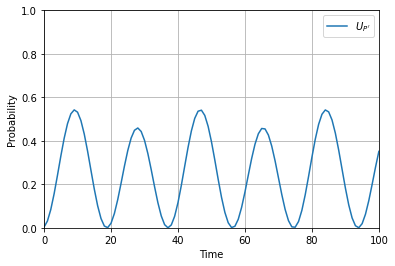

In [49]:
probability_marked_prime = np.sum(evolution_prime[:,marked_nodes],axis=-1)

plt.plot(probability_marked_prime,label='$U_{P\'}$')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.xlim([0,100])
plt.ylim([0,1])
plt.grid()

Other algorithm of quantum search proposed in the [[3]](https://link.springer.com/article/10.1007/s11128-016-1427-4) is using the operator

$$U_M = R_BR_AR_{M_1},$$
where $R_{M_1}$ is an oracle in the first register, so that in our notation from [[1]](...) is

$$U_M = SRSRQ_1.$$

where $R$ is constructed using the original matrix $P$, and $Q_1$ is an oracle in the first register.

The initial state is the same.

In [50]:
Q_1 = sw.Oracle(register=1,marked_nodes=marked_nodes)
R = sw.Reflection(P,name='P')
U_M = sw.Unitary([Q_1,R,S,R,S],name='oracle')
print(U_M)
U_M.info()

SRSRQ₁
Custom unitary: oracle
 1 - Oracle: Register 1: nodes [0 1 2 3 4 5 6]
 2 - Reflection P
 3 - Swap
 4 - Reflection P
 5 - Swap


In [51]:
evolution_oracle = sw.quantum_szegedy_simulator(U_M,initial_state,time_steps=100,measure=1)

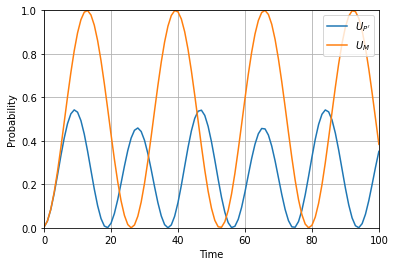

In [52]:
probability_marked_oracle = np.sum(evolution_oracle[:,marked_nodes],axis=-1)

plt.plot(probability_marked_prime,label='$U_{P\'}$')
plt.plot(probability_marked_oracle,label='$U_{M}$')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.xlim([0,100])
plt.ylim([0,1])
plt.grid()

<a name='7'></a>
## 7 - References

- [1] **[Simulator](...)**
- [2] **[Quantum speed-up of Markov chain based algorithms - M. Szegedy](https://ieeexplore.ieee.org/document/1366222)**
- [3] **[Szegedy’s quantum walk with queries - Raqueline A. M. Santos ](https://link.springer.com/article/10.1007/s11128-016-1427-4)**